In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import pickle
from tqdm import tqdm
import re
import json
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
from pensmodule.Generator.train import *
import json
import matplotlib.pyplot as plt

print(torch.cuda.is_available())
print(torch.cuda.device_count())


True
1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0')

## Prepare

- **Config & Data**

In [3]:
from data import *
with open('config.json') as f:
    config = json.load(f)

In [4]:
sources = np.load('../../data2/sources.npy')
target_inputs = np.load('../../data2/target_inputs.npy')
target_outputs = np.load('../../data2/target_outputs.npy')
embedding_matrix = np.load('../../data2/embedding_matrix2.npy')
with open('../../data2/dict.pkl', 'rb') as f:
    news_index,category_dict,word_dict = pickle.load(f)
index2word = {}
for k,v in word_dict.items():
    index2word[v] = k
print(len(word_dict),embedding_matrix.shape)

141910 (141910, 300)


- **Model**

In [5]:
from pensmodule.Generator import HeadlineGen
model = HeadlineGen(config['model'], embedding_matrix, index2word, device, pointer_gen=True).to(device)

C:\Users\毛钟楷\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [6]:
from pensmodule.UserEncoder import NRMS

usermodel = NRMS(embedding_matrix)
usermodel.load_state_dict(torch.load('../../runs/userencoder/NAML-2.pkl'))
usermodel = usermodel.to(device)
usermodel.eval()

NRMS(
  (embed): Embedding(141910, 300, padding_idx=0)
  (attn_word): MultiHeadAttention(
    (W_Q): Linear(in_features=300, out_features=400, bias=True)
    (W_K): Linear(in_features=300, out_features=400, bias=True)
    (W_V): Linear(in_features=300, out_features=400, bias=True)
  )
  (attn_pool_word): AttentionPooling(
    (att_fc1): Linear(in_features=400, out_features=200, bias=True)
    (att_fc2): Linear(in_features=200, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (attn_pool_news): AttentionPooling(
    (att_fc1): Linear(in_features=64, out_features=32, bias=True)
    (att_fc2): Linear(in_features=32, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (drop_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=400, out_features=64, bias=True)
  (criterion): CrossEntropyLoss()
)

- **Load Trainer**

In [7]:
# here you can set different modes for computing coverage scores
trainer = Trainer(config, model, usermodel, device, mode=4, experiment_name='exp')

## Pretrain Seq2seq model

**Noted:**\
**For a fair comparison, here we advise using other source and targets (from your own collected news datasets) for pretraining.**

In [8]:
global_user_embed = np.load('../../data2/global_user_embed2.npy')
global_user_embed = torch.as_tensor(global_user_embed, device=device).float()

In [9]:
trainer._init_optimizer()

In [10]:
for epoch in range(1,4):
    print('epoch:', epoch)
    s_dset = Seq2SeqDataset(sources, target_inputs, target_outputs)
    train_iter = DataLoader(s_dset, batch_size=32, shuffle=True)
    
    trainer.pretrain(train_iter, global_user_embed)
    trainer.save_checkpoint(tag='pretrain_epoch_'+str(epoch))

epoch: 1


  0%|          | 0/3556 [00:00<?, ?it/s]C:\Users\毛钟楷\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
pretrain loss: 57.676:  14%|█▍        | 500/3556 [02:03<12:24,  4.10it/s] 

step= 500, pretrain loss: 64.516


pretrain loss: 52.146:  28%|██▊       | 1000/3556 [04:04<10:25,  4.09it/s]

step=1000, pretrain loss: 59.083


pretrain loss: 49.799:  42%|████▏     | 1500/3556 [06:05<08:19,  4.12it/s]

step=1500, pretrain loss: 56.221


pretrain loss: 47.884:  56%|█████▌    | 2000/3556 [08:10<06:24,  4.04it/s]

step=2000, pretrain loss: 54.283


pretrain loss: 46.826:  70%|███████   | 2500/3556 [10:12<04:19,  4.08it/s]

step=2500, pretrain loss: 52.891


pretrain loss: 45.995:  84%|████████▍ | 3000/3556 [12:14<02:15,  4.11it/s]

step=3000, pretrain loss: 51.811


pretrain loss: 45.256:  98%|█████████▊| 3500/3556 [14:15<00:13,  4.08it/s]

step=3500, pretrain loss: 50.908


pretrain loss: 45.170: 100%|██████████| 3556/3556 [14:28<00:00,  4.09it/s]


Saved ../../runs/seq2seq\exp\checkpoint_pretrain_epoch_1.pth
epoch: 2


pretrain loss: 42.481:  14%|█▍        | 500/3556 [02:02<12:31,  4.07it/s]

step= 500, pretrain loss: 42.368


pretrain loss: 42.193:  28%|██▊       | 1000/3556 [04:06<10:23,  4.10it/s]

step=1000, pretrain loss: 42.249


pretrain loss: 41.999:  42%|████▏     | 1500/3556 [06:10<08:30,  4.03it/s]

step=1500, pretrain loss: 42.089


pretrain loss: 41.764:  56%|█████▌    | 2000/3556 [08:12<06:21,  4.08it/s]

step=2000, pretrain loss: 42.052


pretrain loss: 41.807:  70%|███████   | 2500/3556 [10:17<04:18,  4.09it/s]

step=2500, pretrain loss: 41.948


pretrain loss: 40.714:  84%|████████▍ | 3000/3556 [12:22<02:16,  4.07it/s]

step=3000, pretrain loss: 41.760


pretrain loss: 41.121:  98%|█████████▊| 3500/3556 [14:27<00:13,  4.09it/s]

step=3500, pretrain loss: 41.616


pretrain loss: 40.761: 100%|██████████| 3556/3556 [14:41<00:00,  4.04it/s]


Saved ../../runs/seq2seq\exp\checkpoint_pretrain_epoch_2.pth
epoch: 3


pretrain loss: 37.807:  14%|█▍        | 500/3556 [02:01<12:25,  4.10it/s]

step= 500, pretrain loss: 37.605


pretrain loss: 37.836:  28%|██▊       | 1000/3556 [04:02<10:21,  4.12it/s]

step=1000, pretrain loss: 37.716


pretrain loss: 38.148:  42%|████▏     | 1500/3556 [06:02<08:25,  4.07it/s]

step=1500, pretrain loss: 37.872


pretrain loss: 37.882:  56%|█████▌    | 2000/3556 [08:03<06:22,  4.07it/s]

step=2000, pretrain loss: 37.884


pretrain loss: 37.135:  70%|███████   | 2500/3556 [10:03<04:16,  4.11it/s]

step=2500, pretrain loss: 37.816


pretrain loss: 37.852:  84%|████████▍ | 3000/3556 [12:04<02:15,  4.11it/s]

step=3000, pretrain loss: 37.804


pretrain loss: 37.899:  98%|█████████▊| 3500/3556 [14:06<00:13,  4.07it/s]

step=3500, pretrain loss: 37.796


pretrain loss: 37.969: 100%|██████████| 3556/3556 [14:19<00:00,  4.14it/s]


Saved ../../runs/seq2seq\exp\checkpoint_pretrain_epoch_3.pth


## Train Personalized Generator

- **data loader**

In [8]:
with open('../../data2/TrainUsers.pkl', 'rb') as f:
    TrainUsers = pickle.load(f)
with open('../../data2/TrainSamples.pkl', 'rb') as f:
    TrainSamples = pickle.load(f)

In [9]:
news_scoring = np.load('../../data2/news_scoring2.npy')

In [10]:
i_dset = ImpressionDataset(news_scoring, sources, target_inputs, target_outputs, TrainUsers, TrainSamples)
data_loader = DataLoader(i_dset, batch_size=32, shuffle=True)

- **train**

In [11]:
trainer.load_checkpoint(tag='pretrain_epoch_3')

Loaded ../../runs/seq2seq\exp\checkpoint_pretrain_epoch_3.pth


In [12]:
trainer._init_evaluator_()

In [13]:
trainer._init_context_()

loading news body


In [14]:
optimizer_params={'lr': 0.000001}
scheduler_params={'step_size': 200, 'gamma': 0.98}
trainer._init_optimizer(optimizer_params=optimizer_params,scheduler_params=scheduler_params)

In [15]:
rewards = trainer.train(data_loader,train_option='a2c', tag='mod4')

  0%|          | 0/23850 [00:00<?, ?it/s]C:\Users\毛钟楷\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
train actor loss: 0.355, train critic loss: 0.417, train reward: 2.859:   2%|▏         | 500/23850 [13:52<12:10:28,  1.88s/it] 

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_500.pth
step= 500, train actor loss: -0.150, train critic loss: 0.417, train reward: 2.866


train actor loss: 0.073, train critic loss: 0.388, train reward: 2.957:   4%|▍         | 1000/23850 [28:17<12:09:46,  1.92s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_1000.pth
step=1000, train actor loss: -0.047, train critic loss: 0.388, train reward: 2.956


train actor loss: -0.303, train critic loss: 0.399, train reward: 3.006:   6%|▋         | 1500/23850 [42:09<11:19:23,  1.82s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_1500.pth
step=1500, train actor loss: -0.026, train critic loss: 0.399, train reward: 2.998


train actor loss: -0.749, train critic loss: 0.441, train reward: 3.182:   8%|▊         | 2000/23850 [55:37<10:43:51,  1.77s/it]

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_2000.pth
step=2000, train actor loss: -0.141, train critic loss: 0.441, train reward: 3.057


train actor loss: 0.214, train critic loss: 0.368, train reward: 3.142:  10%|█         | 2500/23850 [1:08:00<9:41:21,  1.63s/it]  

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_2500.pth
step=2500, train actor loss: 0.007, train critic loss: 0.368, train reward: 3.125


train actor loss: -0.654, train critic loss: 0.401, train reward: 3.229:  13%|█▎        | 3000/23850 [1:19:49<9:02:37,  1.56s/it] 

Saved ../../runs/seq2seq\exp\checkpoint_train_mod4_step_3000.pth
step=3000, train actor loss: -0.050, train critic loss: 0.401, train reward: 3.141


train actor loss: -0.662, train critic loss: 0.409, train reward: 3.165:  13%|█▎        | 3000/23850 [1:19:50<9:14:54,  1.60s/it]


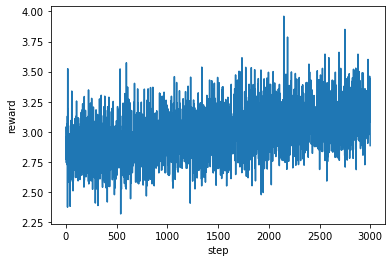

In [16]:
x = np.arange(len(rewards))
fig = plt.gcf()
plt.plot(x[:3000],rewards[:3000])

plt.xlabel("step")
plt.ylabel("reward")
plt.show()

## Test

In [17]:
with open('../../data2/TestUsers.pkl', 'rb') as f:
    TestUsers = pickle.load(f)
with open('../../data2/TestSamples.pkl', 'rb') as f:
    TestSamples = pickle.load(f)

In [20]:
from pensmodule.Generator import *
model_path = '../../runs/seq2seq/exp/checkpoint_train_mod4_step_2000.pth'
model = load_model_from_ckpt(model_path).to(device)
model.eval()

HeadlineGen(
  (embeddings): Embedding(141910, 300)
  (encoder): LSTMEncoder(
    (embeddings): Embedding(141910, 300)
    (rnn): LSTM(300, 64, batch_first=True, dropout=0.2, bidirectional=True)
    (bridge): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (decoder): Decoder_P(
    (embeddings): Embedding(141910, 300)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(300, 128, batch_first=True)
    (attention): Attention(
      (linear_out): Linear(in_features=256, out_features=128, bias=True)
    )
    (transform): ModuleList(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): Linear(in_features=64, out_features=128, bias=True)
    )
    (out): Linear(in_features=128, out_features=141910, bias=True)
    (p_gen_linear): Linear(in_features=128, out_features=1, bias=True)
  )
  (loss_fn): NLLLoss()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [21]:
from pensmodule.UserEncoder import NRMS

usermodel = NRMS(embedding_matrix)
usermodel.load_state_dict(torch.load('../../runs/userencoder/NAML-2.pkl'))
usermodel = usermodel.to(device)
usermodel.eval()

NRMS(
  (embed): Embedding(141910, 300, padding_idx=0)
  (attn_word): MultiHeadAttention(
    (W_Q): Linear(in_features=300, out_features=400, bias=True)
    (W_K): Linear(in_features=300, out_features=400, bias=True)
    (W_V): Linear(in_features=300, out_features=400, bias=True)
  )
  (attn_pool_word): AttentionPooling(
    (att_fc1): Linear(in_features=400, out_features=200, bias=True)
    (att_fc2): Linear(in_features=200, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (attn_pool_news): AttentionPooling(
    (att_fc1): Linear(in_features=64, out_features=32, bias=True)
    (att_fc2): Linear(in_features=32, out_features=1, bias=True)
    (drop_layer): Dropout(p=0.2, inplace=False)
  )
  (drop_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=400, out_features=64, bias=True)
  (criterion): CrossEntropyLoss()
)

In [22]:
i_dset = TestImpressionDataset(news_scoring, sources, TestUsers, TestSamples)
test_iter = DataLoader(i_dset, batch_size=16, shuffle=False)

In [23]:
from pensmodule.Generator.eval import predict
refs, hyps, scores1, scores2, scoresf = predict(usermodel, model, test_iter, device, index2word, beam=False, beam_size=3, eos_id=2)
# refs, hyps, scores1, scores2, scoresf = predict(usermodel, model, test_iter, device, index2word, beam=True, beam_size=3, eos_id=2)

  0%|          | 0/1288 [00:00<?, ?it/s]C:\Users\毛钟楷\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 1288/1288 [01:24<00:00, 15.32it/s]


In [24]:
scores1.mean(), scores2.mean(), scoresf.mean()

(0.2507174604844272, 0.09233970093228006, 0.22024288242613968)

In [25]:
torch.save(model, '../../../model.pkl')